In this exercise we will try to make an Image Classifier via an convolutional neural network. Good luck!

First we import the libraries which we will need (no need to change anything. Just make sure you understand the code)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms


Then we create a couple of folders which we will save stuff into - its a good habit to keep some order. And we will specify that we want to use a GPU if there is one available. (no need to change anything. Just make sure you understand the code)


In [2]:
os.makedirs('data', exist_ok = True)
os.makedirs('models', exist_ok = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


We will now fetch our data. We will use the CIFAR10 dataset. It is a dataset of 32x32x3 pixel color images, divided into 10 different classes (plane, car, bird, cat, deer, dog, frog, horse, ship, truck). Conveniently this dataset can be obtained directly through pytorch. When we load the data, we also apply a couple of transformations to the images. We turn them into tensors and we normalize the pixel values. Right now we do the same for both train and test set, but later you might want to apply more transformations to the trainset - in order to preventing over fitting. (no need to change anything. Just make sure you understand the code)


---



In [3]:
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#transform_train = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(10), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


We now create the pytorch dataloaders. Feel free to play around with the batchsize (But otherwise, there is no need to change anything. Just make sure you understand the code).

In [4]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

If you want to try with the MNIST digit set, the data can be loaded with the script below. Note that some of the later code will need editing for to work on this data.

In [5]:
#trainset = datasets.MNIST( root = 'data', train = True, transform = transforms.ToTensor(), download = True)
#testset = datasets.MNIST(root = 'data', train = False, transform = transforms.ToTensor())

#batch_size = 100

#trainloader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
#trainloader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)

#data=iter(train_dataloader)
#samples,labels=next(data)
#print(f"number of samples{samples.shape}")
#print(f"number of labels {labels.shape}")

Now, lets visualize some images (no need to change anything. Just make sure you understand the code): 

In [6]:
# get some random training images
dataiter=iter(trainloader)
images,labels=next(dataiter)

print(f"number of samples{images.shape} (batch size, color channel, width, hieght)")
print(f"number of labels {labels.shape}")

number of samplestorch.Size([4, 3, 32, 32]) (batch size, color channel, width, hieght)
number of labels torch.Size([4])


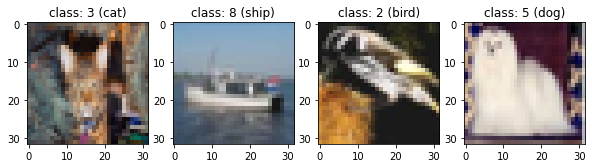

In [7]:
def show_sample(images = images, labels = labels, classes = classes, n = 4):

    plt.figure(figsize=(10,8))
    
    for i in range(n):
      plt.subplot(1,n,i+1)
    
      img = images[i] / 2 + 0.5 # one image from batch and unnormalize
      npimg = img.numpy() # from tensor to numpy
      plt.imshow(np.transpose(npimg, (1, 2, 0))) # from shape (3,32,32) -> (32,32,3) bc imshow...
      plt.title(f'class: {labels[i]} ({classes[labels[i]]})')
    plt.show()

# show images
show_sample(images)

Below you will find a small helper function, which might prove useful later on. It is just a convenience thing that can help you figure out the dimension of you outputs. For instance:

$$
output_{hieght} = \frac{indput_{height} - kernel_{height} + 2 \times padding}{stride} + 1
$$

And if both inputs and kernels are square (which they very often, but not always are) then height and width of both will be the the same.

In [8]:
def conv_dims(input_size, kernel_size, stride, padding):
  output_size = ((input_size - kernel_size + 2 * padding)/ stride)+1
  print(int(output_size))


Now lets define our network! For this task we get our inspiration from early CNNs such as [LeNet](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png) and [Axelnet](https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png). These are basically encoders: Meaning we go from very rich and high dimensiononal representations (color images 32x32x3) to a more abstract and low dimensional representation (classes 1x10). 


The network below needs dimension. You get to fill these in.

- The first conv layer should take a three channel input (color images. for now let this layer ouput 16 channels, use a 3x3 kernel, have a stride 1 and a padding of 1.

- For now, the second conv layer should have 32 output channels, kernel size 3x3, a stride of 1 and a padding of 1

- For now, The third conv layer should have 64 output channels, kernel size 3x3, a stride of 1 and a padding of 1.

- The first dense (linear) layer should take as input the the number of output channels from the last conv layer times the hieght of the last feature map times the width of the last feature map. For now, make the output 256.

- For now, let the second dense layer output be 128

- The last dense layer should have an output=number of classes.

- We use relu for all activations, save the last. The last one is usually a softmax as we are doing classifications. The softmax changes the scores for each class into probabilities which is nice and intuative. But it is not actually needed for the network to work. We can easily use the "energies"/scores to get the mostly likely class. As such I do not have a softmax in the end below. Feel free to experiment then change this. 

Also note that the convolutional layers do not as such care about the width and the height of the inputs - it just execute over almost anything. As such this should not be explicitly specified; only the channels. But you will still need to keep track of how the height and width of how your input/output changes for two reasons. 1) You will need to know the size of the flattened vector when you feed it into the dense layer. 2) If you do not keep track of the dimensions, you will not know when to stop using max/mean/average poolings (or true convolutions).


The following links might prove helpful (please read the docs and quiz your peers before you ask your TA...)

- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

- https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=nn%20maxpool2d#torch.nn.MaxPool2d

- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear

- https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

- https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=1, padding=1)

        # full layers
        self.fc1 = nn.Linear(4 * 4 * 64, 256) #input = last conv output HxWxC
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # other
        self.pool = nn.MaxPool2d(2, 2) 


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x))) # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x))) # 8x8 -> 4x4

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # if you get an error regarding this relu, specify it above as: self.relu1 = nn.ReLU() and so forth.
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [17]:
# EXEMPLE NETWORK FOR TA'S 
# Is it better? Not really.. Well, if you run it for more epochs and use a better optimizer it is.
# But the main point it, that there is a lot of jazz implimented here.
# This might serve as inspiration if students want to improve their network.
# Note: as many of these steps a meant to counter overfitting, more epocs will be needed to get good results.


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride=1, padding=1, bias=False) # no need for bias with batchnorm
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride=1, padding=1, bias=False)


        # full layers
        self.fc1 = nn.Linear(2 * 2 * 256, 1024, bias = False)
        self.fc2 = nn.Linear(1024, 512, bias = False)
        self.fc3 = nn.Linear(512, 10)

        # other
        self.pool = nn.MaxPool2d(2, 2) 
        self.dropout = nn.Dropout(0.1) # for dense layers
        self.dropout2D = nn.Dropout2d(0.1) # for convolutions
        
        self.bn1 = nn.BatchNorm2d(32) # 2D for conv
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(1024) # 1D for dense
        self.bn6 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 32x32 -> 16x16 # if you get an error regarding this relu, specify it above as: self.relu1 = nn.ReLU() and so forth.
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 16x16 -> 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 8x8 -> 4x4
        x = self.pool(self.dropout2D(F.relu(self.bn4(self.conv4(x))))) # 4x4 -> 2x2

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.dropout(F.relu(self.bn5(self.fc1(x))))
        x = F.relu(self.bn6(self.fc2(x)))
        # x = F.softmax(self.fc3(x), 1)
        self.fc3(x)

        return x



net = Net().to(device)

Now we define our optimization strategy. For now we just use plain old Gradient decent, but feel free to experiment later on.  The following link might be useful. Also feel free the expiriment with any hyper paremeters here (e.g learning rate and momentum).

- https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD


In [18]:
lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

#optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum)
#optimizer = optim.Adam(net.parameters(), lr=lr)

Now for the training loop. Fill in the missing steps and run it! I have set the number of epochs to just 2 for now. Feel free to change it later.

In [19]:
n_epochs = 2

for epoch in range(n_epochs):  # loop over the dataset multiple times

    history_loss = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # if you run on gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)

        # loss + backward
        loss = criterion(outputs, labels)
        loss.backward()
        
        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history_loss.append(running_loss / len(trainset))
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.666
[1,  4000] loss: 3.047
[1,  6000] loss: 2.501
[1,  8000] loss: 2.229
[1, 10000] loss: 2.062
[1, 12000] loss: 1.990
[2,  2000] loss: 1.845
[2,  4000] loss: 1.811
[2,  6000] loss: 1.751
[2,  8000] loss: 1.708
[2, 10000] loss: 1.612
[2, 12000] loss: 1.604
Finished Training


Save your model - this is always a prudent thing todo

In [20]:
PATH = 'models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

Now we will turn our attention to the test set. If you have just run you model, you do not strictly need to load the saved version, but it is a prudent thing to do (There is no need to change anything. Just make sure you understand the code). 



In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# this step is not needed if you have just trained your network
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

Lets look at some predictions (There is no need to change anything. Just make sure you understand the code). 


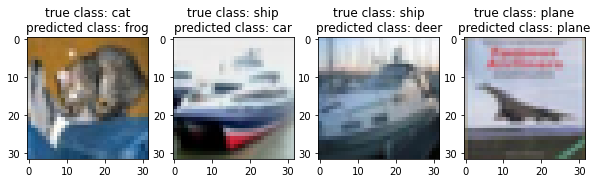

In [22]:
def show_predictions(images = images, labels = labels, classes = classes, predicted = predicted, n = 4):

    plt.figure(figsize=(10,8))
    
    for i in range(n):
      plt.subplot(1,n,i+1)
    
      img = images[i] / 2 + 0.5 # one image from batch and unnormalize
      npimg = img.numpy() # from tensor to numpy
      plt.imshow(np.transpose(npimg, (1, 2, 0))) # from shape (3,32,32) -> (32,32,3) bc imshow...
      plt.title(f'true class: {classes[labels[i]]}\npredicted class: {classes[predicted[i]]}')
    plt.show()

# show images
show_predictions(images)

Calculate the over all accuracy. Remember there are 10 classes so random would be something like 10% - not 50% (There is no need to change anything. Just make sure you understand the code). 

In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


And now for each class (There is no need to change anything. Just make sure you understand the code).

In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.2 %
Accuracy for class: car   is 65.4 %
Accuracy for class: bird  is 31.6 %
Accuracy for class: cat   is 26.0 %
Accuracy for class: deer  is 37.3 %
Accuracy for class: dog   is 39.8 %
Accuracy for class: frog  is 54.5 %
Accuracy for class: horse is 52.0 %
Accuracy for class: ship  is 59.7 %
Accuracy for class: truck is 56.9 %


DONE! 

Or well, this was just the first step. Now you should go back and see if you can improve on your results. The logic should be as follows: first achieve a good fit and mitigate over fitting. 

So, to increase the fit/capacity of you network:

- run for more epochs
- Try to increase the number of channels in you conv layers.
- Try to increase to number of nodes in your dense layers
- Try to increase the depth of you network (more conv or dense layers)
- Try adding batch normalization to your layers (2d for conv layers, 1d for dense layers)
- Try a better optimization strategy (RMSprop, Adam)

Now see if you can decrease overfitting, for instance:
- Ad dropout layers to your network (2d for conv layers, 1d for dense layers)
- Try adding more transformations to your training set.  
- Smaller batch size

The following links might prove helpful
- https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm#torch.nn.BatchNorm1d

- https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop

- https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

- https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d

- https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

- https://pytorch.org/vision/0.8/transforms.html
